In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import numpy as np
import tensorflow as tf
import selfies as sf
import counterstone as cs
import warnings

warnings.filterwarnings('ignore')
sns.set_context('notebook')
sns.set_style('dark',  {'xtick.bottom':True, 'ytick.left':True, 'xtick.color': '#666666', 'ytick.color': '#666666',
                        'axes.edgecolor': '#666666', 'axes.linewidth':     0.8 , 'figure.dpi': 300})
color_cycle = ['#1BBC9B', '#F06060', '#5C4B51', '#F3B562', '#6e5687']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=color_cycle) 
#soldata = pd.read_csv('https://dataverse.harvard.edu/api/access/datafile/3407241?format=original&gbrecs=true')
# had to rehost because dataverse isn't reliable
soldata = pd.read_csv('https://github.com/whitead/dmol-book/raw/master/data/curated-solubility-dataset.csv')
features_start_at = list(soldata.columns).index('MolWt')
np.random.seed(0)

In [2]:
# scramble them
soldata = soldata.sample(frac=1).reset_index(drop=True)
soldata.head()

,ID,Name,InChI,InChIKey,SMILES,Solubility,SD,Ocurrences,Group,MolWt,...,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT
0,B-4206,diuron,InChI=1S/C9H10Cl2N2O/c1-13(2)9(14)12-6-3-4-7(1...,XMTQQYYKAHVGBJ-UHFFFAOYSA-N,CN(C)C(=O)Nc1ccc(Cl)c(Cl)c1,-3.744300,1.227164,5,G4,233.098,...,1.0,76.0,1.0,0.0,0.0,1.0,32.34,92.603980,2.781208,352.665233
1,F-988,7-(3-amino-3-methylazetidin-1-yl)-8-chloro-1-c...,InChI=1S/C17H17ClFN3O3/c1-17(20)6-21(7-17)14-1...,DUNZFXZSFJLIKR-UHFFFAOYSA-N,CC1(N)CN(C2=C(Cl)C3=C(C=C2F)C(=O)C(C(=O)O)=CN3...,-5.330000,0.000000,1,G1,365.792,...,3.0,132.0,2.0,2.0,2.0,4.0,88.56,147.136366,2.001398,973.487509
2,C-1996,4-acetoxybiphenyl; 4-biphenylyl acetate,InChI=1S/C14H12O2/c1-11(15)16-14-9-7-13(8-10-1...,MISFQCBPASYYGV-UHFFFAOYSA-N,CC(=O)OC1=CC=C(C=C1)C2=CC=CC=C2,-4.400000,0.000000,1,G1,212.248,...,2.0,80.0,2.0,0.0,0.0,2.0,26.30,94.493449,2.228677,471.848345
3,A-3055,methane dimolybdenum,InChI=1S/CH4.2Mo/h1H4;;,JAGQSESDQXCFCH-UHFFFAOYSA-N,C.[Mo].[Mo],-3.420275,0.409223,2,G3,207.923,...,0.0,20.0,0.0,0.0,0.0,0.0,0.00,49.515427,-0.000000,2.754888
4,A-2575,ethyl 4-[[(methylphenylamino)methylene]amino]b...,InChI=1S/C17H18N2O2/c1-3-21-17(20)14-9-11-15(1...,GNGYPJUKIKDJQT-UHFFFAOYSA-N,CCOC(=O)c1ccc(cc1)N=CN(C)c2ccccc2,-5.450777,0.000000,1,G1,282.343,...,5.0,108.0,2.0,0.0,0.0,2.0,41.90,124.243431,2.028889,606.447052


In [3]:
# filter out long smiles
smask = [len(s) <= 96 for s in soldata.SMILES] 
print(f'Removed {soldata.shape[0] - sum(smask)} long SMILES strings')
filtered_soldata = soldata[smask]
# convert SMILES into SELFIES
smiles = list(filtered_soldata.SMILES)
selfies = [sf.encoder(x) for x in smiles]
# not all smiles are converted to selfies; filter again
smask2 = [s is not None for s in selfies] 
filtered_soldata = filtered_soldata[smask2]
# filtered selfies
selfies = list(filter(None, [sf.encoder(x) for x in smiles]))

# make tokenizer with 128 size vocab and 
# have it examine all text in dataset
vocab_size = 128
tokenizer = tf.keras.preprocessing.text.Tokenizer(vocab_size, filters='', char_level=True)
tokenizer.fit_on_texts(selfies)

Removed 285 long SMILES strings


In [4]:
# now get padded sequences
seqs = tokenizer.texts_to_sequences(selfies)
#seqs = tokenizer.texts_to_sequences(filtered_soldata.SMILES)
print(f'Number of molecules: {len(seqs)}')
padded_seqs = tf.keras.preprocessing.sequence.pad_sequences(seqs, padding='post')

# Now build dataset
data = tf.data.Dataset.from_tensor_slices((padded_seqs, filtered_soldata.Solubility))
# now split into val, test, train and batch
N = len(data)  
split = int(0.1 * N)
test_data = data.take(split).batch(16)
nontest = data.skip(split)
val_data, train_data = nontest.take(split).batch(16), nontest.skip(split).shuffle(1000).batch(16)

Number of molecules: 9657


In [5]:
model = tf.keras.Sequential()

# make embedding and indicate that 0 should be treated as padding mask
model.add(tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=16, mask_zero=True))

# RNN layer
model.add(tf.keras.layers.GRU(128))
# a dense hidden layer
model.add(tf.keras.layers.Dense(64, activation='relu'))
# regression, so no activation
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          2048      
_________________________________________________________________
gru (GRU)                    (None, 128)               56064     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 66,433
Trainable params: 66,433
Non-trainable params: 0
_________________________________________________________________


In [6]:
model.compile(tf.optimizers.Adam(1e-2), loss='mean_squared_error')
result = model.fit(train_data, validation_data=val_data, epochs=10, verbose=0)

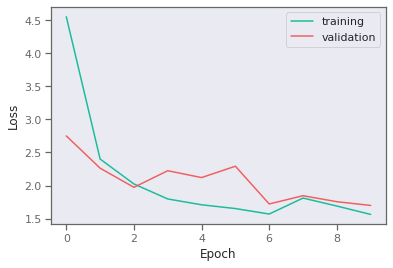

In [7]:
plt.plot(result.history['loss'], label='training')
plt.plot(result.history['val_loss'], label='validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

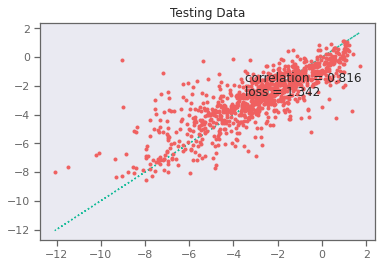

In [8]:
yhat = []
test_y = []
for x,y in test_data:
    yhat.extend(model(x).numpy().flatten())
    test_y.extend(y.numpy().flatten())
yhat = np.array(yhat)
test_y = np.array(test_y)

# plot test data
plt.plot(test_y, test_y, ':')
plt.plot(test_y, yhat, '.')
plt.text(min(y) + 1, max(y) - 2, f'correlation = {np.corrcoef(test_y, yhat)[0,1]:.3f}')
plt.text(min(y) + 1, max(y) - 3, f'loss = {np.sqrt(np.mean((test_y - yhat)**2)):.3f}')
plt.title('Testing Data')
plt.show()


## CF explanation:

In the following example let's say we would like our molecules to return a solubility value of -3.5. Here we use `counterstone` algorithm to create counter factual explanations. In other words, we would like to see what are the minimal mutations that could to be done to our input structure to get our desired solubility.

In [9]:
def predictor_function(smile_list,selfies):
     #let's say we want the solubility to be this value
    example_seqs = tokenizer.texts_to_sequences(smile_list)
    padded_exseq = tf.keras.preprocessing.sequence.pad_sequences(example_seqs, padding='post')
    labels = model.predict(padded_exseq)
    target_sol = np.ones(len(labels.flatten()))*(-3.5)

    return abs(target_sol-labels.flatten())<0.8 

In [10]:
cf_exp,space = cs.explain(smiles[2], predictor_function, stoned_kwargs={'num_samples': 10000, 'max_mutations': 2})

Round Complete with 10000
Round Complete with 10000
Adjusting max_k to 3
Starting with 12587 explanations


In [11]:
cf_exp

[Explanation(smiles='CC(=O)OC1=CC=C(C=C1)C2=CC=CC=C2', selfies='', similarity=1.0, index=0, position=array([15.79185425, -0.58203496]), is_counter=True, is_base=True),
 Explanation(smiles='CC(=[P+])Oc1ccc(-c2ccccc2)cc1', selfies=None, similarity=0.803921568627451, index=602, position=array([12.16818621,  3.18599539]), is_counter=True, is_base=False),
 Explanation(smiles='CC(=S)Oc1ccc(-c2ccccc2)cc1', selfies='', similarity=0.803921568627451, index=7034, position=array([12.15080435,  3.18814921]), is_counter=True, is_base=False),
 Explanation(smiles='[C+]=C(C)Oc1ccc(-c2ccccc2)cc1', selfies=None, similarity=0.803921568627451, index=8870, position=array([12.16879556,  3.18503284]), is_counter=True, is_base=False),
 Explanation(smiles='CC(=O)Oc1ccc2cccc-2cc1', selfies='', similarity=0.8297872340425532, index=6120, position=array([12.44884674, -1.61389671]), is_counter=False, is_base=False),
 Explanation(smiles='CC(=O)Oc1ccc(C2=C=C2)cc1', selfies='', similarity=0.5471698113207547, index=9317

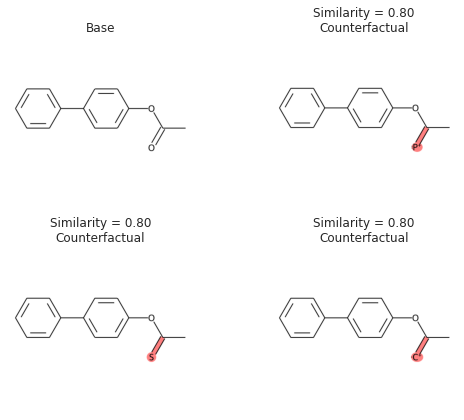

In [12]:
fkw = {'figsize': (8,6)}
cs.plot_explanation(cf_exp, figure_kwargs=fkw, mol_size=(450,400))
plt.savefig('rnn-simple.png', dpi=90)

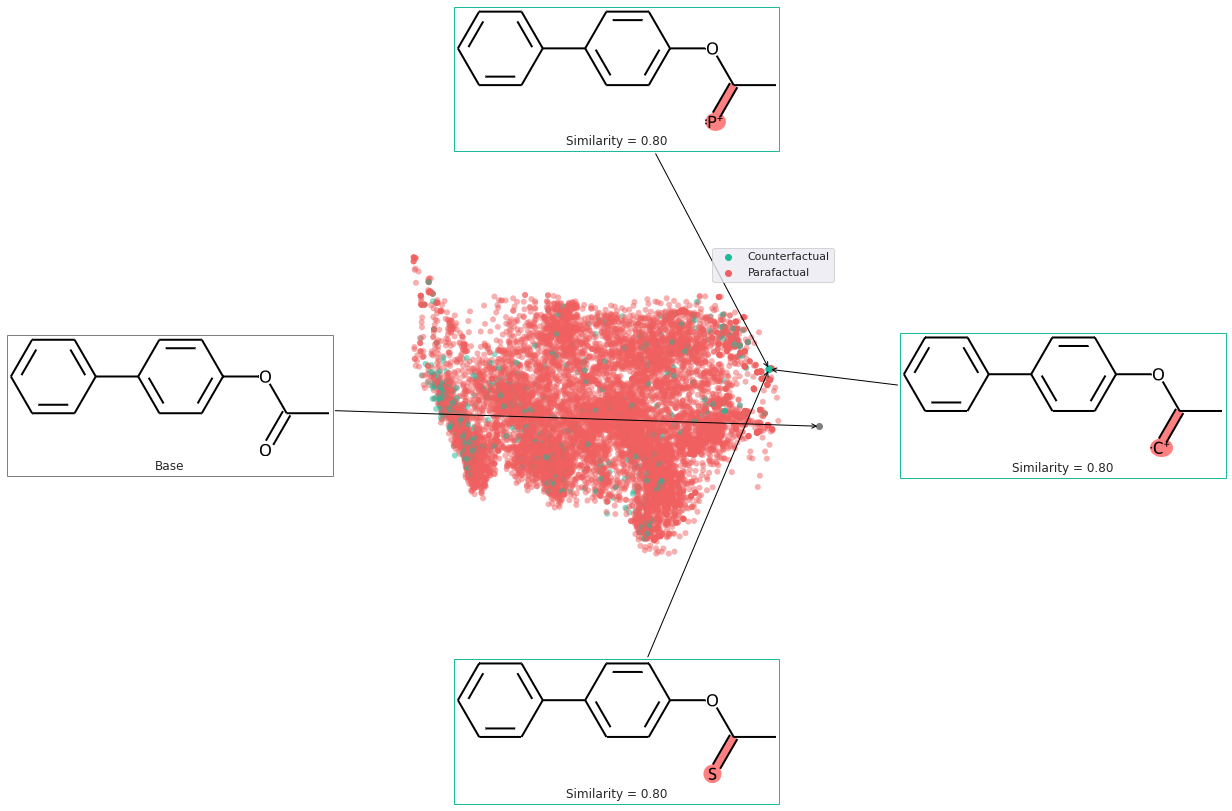

In [13]:
fkw = {'figsize': (8,6)}
cs.plot_explanation(cf_exp, space, figure_kwargs=fkw, mol_size=(350,300))
plt.savefig('rnn-space.png', bbox_inches='tight', dpi=90)